In [2]:
import cv2
import os
import re
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import csv
import pandas as pd
import keras
from keras import models,Model
from keras.layers import Dense,GaussianNoise, Dropout,Input
%matplotlib inline

/home/joker/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
dataSet = []
person = []
horiSet = []

count = 0
folder = "/home/joker/PycharmProjecta/ML_PCA_Image/MLFaceImages"
for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, (520, 520))
        img = img.flatten()
        img = np.ravel(img)
        if img is not None:
            numbers = re.findall('\d+',filename)
            numbers = list(map(int,numbers))
            person.append(numbers[0])
            horiSet.append(img.T)
            dataSet.append(img)
            count = count + 1

In [4]:
dataSet = np.array(dataSet)
test = pd.DataFrame(dataSet)

person = np.array(person)
test['id'] = person.transpose()

unique_person = test['id']
unique_person = np.array(unique_person)
unique_person = np.unique(unique_person)
key = range(len(unique_person))

roll_dict = dict( zip(unique_person, key))
# print(roll_dict)

mapped_roll = np.vectorize(roll_dict.get)(person)
# print(mapped_roll)
test['id'] = mapped_roll.transpose()

y = test['id'].values.astype('int64')
images = test.drop(['id'], axis=1, inplace=False)
x = (images.values).astype('uint8')
split_test_size = 0.30

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = split_test_size, random_state=13)
# print(test)

In [5]:
scalar = StandardScaler()
scalar.fit(X_train)
X_sc_train = scalar.transform(X_train)
X_sc_test = scalar.transform(X_test)

/home/joker/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


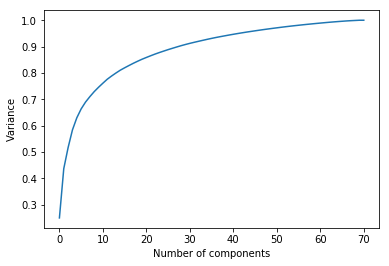

In [6]:
pca = PCA(n_components=127)
pca.fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance')

(71, 811200)
(71, 60)


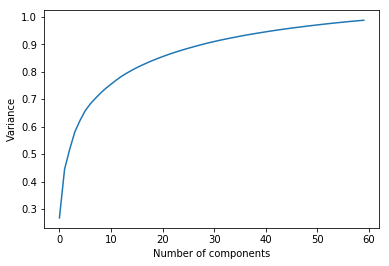

In [ ]:
pca = PCA(n_components=60)
X_pca_train = pca.fit_transform(X_sc_train)
X_pca_test = pca.transform(X_sc_test)

pca_std = np.std(X_pca_train)
print(X_sc_train.shape)
print(X_pca_train.shape)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance')

In [ ]:
model = models.Sequential()
layers = 1
units = 108

model.add(Dense(units, input_dim=150, activation='relu'))

for i in range(layers):
    model.add(Dense(units, activation='relu'))
    model.add(Dropout(0.1))
model.add(Dense(len(mapped_roll), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='Rmsprop', metrics=['accuracy'])
model.fit(X_pca_train, Y_train, batch_size=100, epochs=150, verbose=2)

In [ ]:
predictions = model.predict_classes(X_pca_test, verbose=0)

def write_predictions(predictions, fname):
    pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "Label": predictions}).to_csv(fname, index=False, header=True)

write_predictions(predictions, "pca-keras-mlp.csv")

In [ ]:
result = pd.read_csv('pca-keras-mlp.csv')
result = result['Label']
result = np.array(result)

error = np.array( Y_test - result)
error = error[error != 0]

error = error.size/Y_test.size
print("Accuracy: ",1-error)

In [ ]:
mapped_roll